# A Scalable Approach to Quantum Simulation via Projection-Based Embedding

This notebook will allow you to reproduce the results presented in the paper.

- Example Molecules
- Water Bond Dissociation
- Cyclopentane Resource Scaling

The results presented in our paper can be reproduced with a single click using the `Run All` button at the top of the notebook. (Assuming that the `Nbed` package is installed of course.)

To use the provided data, place this in the `data/` folder and run the code in Section 1, followed by that in Section 3.

## 1. Configuration and convenience functions.

### Small Molecules

In [197]:
from symmer import PauliwordOp
from scipy.sparse.linalg import eigsh
from pathlib import Path
from nbed.utils import save_ordered_xyz_file, pubchem_mol_geometry
from datetime import datetime


def ground(hamiltonian):
    sparse_ham = PauliwordOp.from_openfermion(hamiltonian).to_sparse_matrix
    eigenvalue, _ = eigsh(sparse_ham, k=1, which="SA")
    return eigenvalue[0]


def find_and_save(mol_name):
    if Path(f"./molecular_structures/{mol_name}.xyz").exists():
        print(f"xyz file for {mol_name} already exists.\n")
        return

    geo_dict = pubchem_mol_geometry(mol_name)
    print("Molecule geometry:")
    print(geo_dict)
    save_ordered_xyz_file(mol_name, geo_dict, [0])
    print(f"xyz file for {mol_name} created.\n")


def print_results(result, active):
    print(
        f"Qubits\t\tMu:{result[active]['mu']['n_qubits']}/Huz:{result[active]['huz']['n_qubits']}/Full:{result['full']['n_qubits']}"
    )
    print(
        f"Terms\t\tMu:{result[active]['mu']['terms']}/Huz:{result[active]['huz']['terms']}/Full:{result['full']['terms']}"
    )
    print(f'DFT:\t\t{result["e_dft"]}')
    # print(f"CCSD Emb:\t{result['mu']['e_ccsd']}/{result['huz']['e_ccsd']}")
    print(f"Mu Emb:\t\t{result[active]['mu']['e_ccsd']}")
    print(f"Huz Emb:\t{result[active]['huz']['e_ccsd']}")
    print(f"CCSD:\t\t{result['full']['e_ccsd']}")
    print("\n")


def save_data(result, mol_name, localisation, force: bool):
    import os

    if not os.path.isdir("data"):
        os.mkdir("data")

    savefile = f"data/{mol_name}_{localisation}.json"

    with open(savefile, "w") as f:
        json.dump(result, f, indent=4)
        print(f"{savefile} created.")

In [183]:
mol_dict = {
    "acetonitrile": 2,
    "N-methylmethanamine": 2,
    "acetaldehyde": 3,
    "formamide": 3,
    "ethanamine": 3,
    "ethanol": 2,
    "fluoroethane": 2,
}

In [184]:
acetaldehyde = """
7
 
O	1.1443	0.2412	0
H	0.1478	-1.5252	-0.0007
C	0.113	-0.4226	0
C	-1.2574	0.1815	0
H	-1.7938	-0.1493	0.8924
H	-1.1865	1.2719	0.0016
H	-1.7928	-0.1468	-0.8938
"""

acetonitrile = """
6
 
N	1.2608	0	0
C	0.1006	0	0
C	-1.3613	0	0
H	-1.75	-0.8301	0.5974
H	-1.7501	-0.1022	-1.0175
H	-1.75	0.9324	0.4202
"""

ethanol = """
9
 
H	-1.1291	0.8364	0.8099
O	-1.1712	0.2997	0
C	-0.0463	-0.5665	0
H	-0.0958	-1.212	0.8819
H	-0.0952	-1.1938	-0.8946
C	1.2175	0.2668	0
H	2.105	-0.372	-0.0177
H	1.2426	0.9307	-0.8704
H	1.2616	0.9052	0.8886
"""

ethanamine = """
10
 
H	1.1926	-0.9044	0.8134
H	1.1926	-0.9044	-0.8134
N	1.2133	-0.2902	0
C	0.0295	0.5602	0
H	0.0512	1.2078	0.8824
H	0.0511	1.2078	-0.8825
C	-1.2428	-0.27	0
H	-1.2991	-0.9094	-0.8874
H	-1.2991	-0.9093	0.8875
H	-2.1202	0.3846	0
"""

N_methylmethanamine = """
10
 
N	0.0001	-0.5504	0
H	0	-1.1423	0.8302
C	-1.2001	0.2752	0
C	1.2001	0.2752	0
H	-1.2506	0.9105	0.8903
H	-2.0853	-0.3685	-0.0051
H	-1.2467	0.906	-0.8936
H	2.0853	-0.3682	-0.005
H	1.2506	0.9106	0.8903
H	1.2467	0.906	-0.8937
"""

formamide = """
6
 
O	1.128	0.2091	0
C	0.0598	-0.3882	0
H	-0.0014	-1.4883	-0.0001
N	-1.1878	0.1791	0
H	-1.3085	1.1864	0.0001
H	-2.0305	-0.3861	-0.0001
"""

fluoroethane = """
8
 
F	1.1298	0.3032	0
C	0.0745	-0.5534	0
C	-1.2043	0.2502	0
H	0.1472	-1.1828	-0.891
H	0.1471	-1.1828	0.891
H	-2.0791	-0.4057	-0.0001
H	-1.2472	0.8979	0.881
H	-1.2471	0.898	-0.8809
"""

cyclopentane = """
15
 
C	-1.0551	-0.658	0.2446
C	-0.9716	0.7805	-0.2349
C	0.2952	-1.2327	-0.1536
C	0.4469	1.1915	0.1309
C	1.2846	-0.0814	0.013
H	-1.1742	-0.6896	1.334
H	-1.8887	-1.202	-0.2082
H	-1.1092	0.8265	-1.3217
H	-1.724	1.422	0.2327
H	0.5683	-2.1041	0.4489
H	0.2713	-1.5481	-1.2036
H	0.821	1.9934	-0.5127
H	0.4759	1.556	1.1648
H	1.8979	-0.2164	0.9106
H	1.9655	-0.0323	-0.8435
"""

mol_structures = {
    "acetonitrile": acetonitrile,
    "N-methylmethanamine": N_methylmethanamine,
    "acetaldehyde": acetaldehyde,
    "formamide": formamide,
    "ethanamine": ethanamine,
    "ethanol": ethanol,
    "fluoroethane": fluoroethane,
    "cyclopentane": cyclopentane,
}

In [185]:
from pathlib import Path
from pyscf.gto import Mole
import nbed
from nbed.driver import NbedDriver
from nbed.ham_builder import HamiltonianBuilder
from nbed.ham_converter import HamiltonianConverter
from openfermion import count_qubits
import json
from pyscf import cc


def get_results(
    mol_name,
    active_atoms,
    localisation="pipek-mezey",
    qubits=None,
    force=True,
    unrestricted=False,
    taper=True,
    basis="6-31g",
):
    print(
        f"\nGetting results for:\n\t{mol_name}\n\t{active_atoms} atoms\n\t{localisation} localisation\n"
    )
    geometry = mol_structures[mol_name]

    config = {}
    # We pass these to the driver.
    config["localization"] = localisation
    config["basis"] = basis
    config["xc_functional"] = "b3lyp5"
    config["convergence"] = 1e-6
    config["charge"] = 0
    config["mu_level_shift"] = 1e6
    config["run_ccsd_emb"] = True
    config["run_fci_emb"] = False
    config["max_ram_memory"] = 8_000
    config["pyscf_print_level"] = 1
    config["init_huzinaga_rhf_with_mu"] = True

    result = {}
    # with open(geometry, "r") as f:
    #     result["geometry"] = f.read()
    result["geometry"] = geometry
    result.update(config)
    transform = "jordan_wigner"

    for active in active_atoms:
        print(f"Starting driver with {active} active atoms.")
        driver = NbedDriver(
            geometry=geometry, n_active_atoms=active, projector="both", **config
        )
        print("Driver finished.")
        if active == 1 or True:
            result["full"] = {}
            result["e_dft"] = driver._global_ks.e_tot
            full_builder = HamiltonianBuilder(
                driver._global_hf,
                constant_e_shift=driver._global_hf.energy_nuc(),
                transform=transform,
            )
            full_ham = full_builder.build(qubits, taper=taper)
            result["full"]["qham"] = HamiltonianConverter(full_ham)._intermediate
            result["full"]["terms"] = len(full_ham.terms)
            result["full"]["n_qubits"] = count_qubits(full_ham)
            result["full"]["classical_energy"] = 0
            result["full"]["ground"] = None
            result["full"]["e_ccsd"] = (
                driver._global_ccsd.e_tot + driver._global_ccsd.ccsd_t()
            )
            print("Full system Hamiltonian built.")

        result[active] = {}
        # Mu shift result
        mu_builder = HamiltonianBuilder(
            driver._mu["scf"], driver._mu["classical_energy"], transform=transform
        )
        qham = mu_builder.build(qubits, taper=taper)
        result[active]["mu"] = {}
        result[active]["mu"]["qham"] = HamiltonianConverter(qham)._intermediate
        result[active]["mu"]["terms"] = len(qham.terms)
        result[active]["mu"]["n_qubits"] = count_qubits(qham)
        result[active]["mu"]["classical_energy"] = driver._mu["classical_energy"]
        result[active]["mu"]["ground"] = None
        result[active]["mu"]["e_ccsd"] = driver._mu["e_ccsd"]
        print("Mu finished.")

        # Huzinaga result
        huz_builder = HamiltonianBuilder(
            driver._huzinaga["scf"],
            driver._huzinaga["classical_energy"],
            transform=transform,
        )
        qham = huz_builder.build(qubits, taper=taper)
        result[active]["huz"] = {}
        result[active]["huz"]["qham"] = HamiltonianConverter(qham)._intermediate
        result[active]["huz"]["terms"] = len(qham.terms)
        result[active]["huz"]["n_qubits"] = count_qubits(qham)
        result[active]["huz"]["classical_energy"] = driver._huzinaga["classical_energy"]
        result[active]["huz"]["ground"] = None
        result[active]["huz"]["e_ccsd"] = driver._huzinaga["e_ccsd"]
        print("Huzinaga finished.")

        # untapered_mu = mu_builder.build(taper=False)
        # untapered_huz = huz_builder.build(taper=False)
        # untapered_full = full_builder.build(taper=False)
        # print(f"Ground diff with tapering {result['mu']['ground']-ground(untapered_mu)}/{result['huz']['ground']-ground(untapered_huz)}")
        # print(f"Untapered Qubits {count_qubits(untapered_mu)}/{count_qubits(untapered_huz)}/{count_qubits(untapered_full)}")
        # print(f"Untapered Terms {len(untapered_mu.terms)}/{len(untapered_huz.terms)}/{len(untapered_full.terms)}")

        print_results(result, active)

    result["mol_name"] = mol_name
    result["transform"] = transform
    result["qubit_limit"] = qubits

    save_data(result, mol_name, localisation, force)
    print("\n")
    return result

In [186]:
import pandas as pd


def format_data(data):
    df = pd.DataFrame(data).T
    df.head()

    threes = pd.DataFrame(df["3"].dropna().to_list(), index=df["3"].dropna().index)
    twos = pd.DataFrame(df["2"].dropna().to_list(), index=df["2"].dropna().index)
    embeddings = pd.concat([threes, twos], axis=0)
    full_vals = pd.DataFrame([v for v in df["full"].to_list()], index=df["mol_name"])
    mu_vals = pd.DataFrame([v for v in embeddings["mu"]], index=embeddings.index)
    huz_vals = pd.DataFrame([v for v in embeddings["huz"]], index=embeddings.index)

    energies = pd.concat(
        [df["e_dft"], full_vals["e_ccsd"], mu_vals["e_ccsd"], huz_vals["e_ccsd"]],
        keys=["DFT", "Full", "Mu", "Huz"],
        axis=1,
    )
    energies["dft_diffs"] = (
        (energies["DFT"] - energies["Full"]) / energies["Full"]
    ).apply(lambda x: np.log10(abs(x)))
    energies["mu_diffs"] = (
        (energies["Mu"] - energies["Full"]) / energies["Full"]
    ).apply(lambda x: np.log10(abs(x)))
    energies["huz_diffs"] = (
        (energies["Huz"] - energies["Full"]) / energies["Full"]
    ).apply(lambda x: np.log10(abs(x)))
    energies = energies.reindex(
        [
            "N-methylmethanamine",
            "acetaldehyde",
            "acetonitrile",
            "ethanamine",
            "ethanol",
            "fluoroethane",
            "formamide",
        ]
    )

    dft_diffs = energies["dft_diffs"].to_list()
    mu_diffs = energies["mu_diffs"].to_list()
    huz_diffs = energies["huz_diffs"].to_list()

    dft_diffs = np.array(dft_diffs)
    mu_diffs = np.array(mu_diffs)
    huz_diffs = np.array(huz_diffs)

    full_vals = full_vals.reindex(energies.index)
    mu_vals = mu_vals.reindex(energies.index)
    huz_vals = huz_vals.reindex(energies.index)

    mol_names = energies.index.to_list()

    return mol_names, full_vals, mu_vals, huz_vals, energies

In [187]:
import matplotlib.pyplot as plt
import numpy as np


def plot_results(loc, mol_names, full_vals, mu_vals, huz_vals, energies):

    x = np.arange(len(mol_names))  # the label locations
    width = 0.1  # the width of the bars

    formatting = {"edgecolor": "black", "linewidth": 1}

    dft_diffs = energies["dft_diffs"].to_list()
    mu_diffs = energies["mu_diffs"].to_list()
    huz_diffs = energies["huz_diffs"].to_list()

    dft_diffs = np.array(dft_diffs)
    mu_diffs = np.array(mu_diffs)
    huz_diffs = np.array(huz_diffs)

    fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(12, 9))
    huz_es = ax1.bar(
        x - width,
        huz_diffs + 4,
        width,
        label="Huzinaga",
        color="lightgrey",
        **formatting,
    )
    mu_es = ax1.bar(
        x,
        mu_diffs + 4,
        width,
        label="$\mu$-shift",
        color="darkorange",
        hatch="///",
        **formatting,
    )
    def_es = ax1.bar(
        x + width, dft_diffs + 4, width, label="DFT", color="midnightblue", **formatting
    )

    huz_qubs = ax2.bar(
        x - width,
        huz_vals["n_qubits"],
        width,
        label="Huzinaga",
        color="lightgrey",
        **formatting,
    )
    mu_qubs = ax2.bar(
        x,
        mu_vals["n_qubits"],
        width,
        label="$\mu$-shift",
        color="darkorange",
        hatch="///",
        **formatting,
    )
    full_qubs = ax2.bar(
        x + width,
        full_vals["n_qubits"],
        width,
        label="Full system",
        color="midnightblue",
        **formatting,
    )

    huz_ts = ax3.bar(
        x - width,
        np.log10(huz_vals["terms"]),
        width,
        label="Huzinaga",
        color="lightgrey",
        **formatting,
    )
    mu_ts = ax3.bar(
        x,
        np.log10(mu_vals["terms"]),
        width,
        label="$\mu$-shift",
        color="darkorange",
        hatch="///",
        **formatting,
    )
    full_ts = ax3.bar(
        x + width,
        np.log10(full_vals["terms"]),
        width,
        label="Full system",
        color="midnightblue",
        **formatting,
    )

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax1.set_ylabel("$log_{10} (\dfrac{|\Delta E|}{H_0})$")
    ax1.set_title("(a) Molecular Ground-state Energy.")
    ax1.set_ylim(0, 2)
    ax1.set_yticks([0, 1, 2], labels=["-4", "-3", "-2"])
    ax1.set_xticks(x)
    ax1.set_xticklabels(mol_names)
    # ax1.tick_params(axis="x", rotation=50)
    # ax1.legend()

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax2.set_ylabel("Qubits")
    ax2.set_title("(b) Number of qubits in Hamiltonian.")
    ax2.set_xticks(x)
    ax2.set_xticklabels(mol_names)
    ax2.tick_params(axis="x", rotation=50)
    # ax2.legend()

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax3.set_ylabel("$log_{10}|H|$")
    ax3.set_title("(c) Number of terms in Hamiltonian.")
    ax3.set_ylim(3, 6)
    ax3.set_yticks([3, 4, 5, 6])
    ax3.set_xticks(x)
    ax3.set_xticklabels(mol_names)
    ax3.tick_params(axis="x", rotation=50)
    # ax3.legend()

    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate(
                "{}".format(height),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha="center",
                va="bottom",
            )

    for ax in fig.get_axes():
        ax.label_outer()

    # autolabel(rects3)
    # autolabel(rects2)
    fig.suptitle(f"{loc.title()} Localisation", fontsize="xx-large")
    fig.set_size_inches(8, 8)
    fig.legend(["Huzinaga", "$\mu$-shift", "Full System"], loc="lower center", ncol=3)
    fig.tight_layout()
    plt.show()

In [188]:
def print_tables(loc, mol_names, full_vals, mu_vals, huz_vals, energies):

    print(f"{loc.title()} Localisation")
    print("\nQUBITS")
    qubits = pd.concat(
        [full_vals["n_qubits"], mu_vals["n_qubits"], huz_vals["n_qubits"]],
        keys=["Full", "Mu", "Huz"],
        axis=1,
    )
    print(qubits)

    print("\nTERMS")
    terms = pd.concat(
        [full_vals["terms"], mu_vals["terms"], huz_vals["terms"]],
        keys=["Full", "Mu", "Huz"],
        axis=1,
    )
    print(terms)

    print("\n Full System Values")
    ref_table = pd.concat(
        [energies["Full"] - energies["DFT"], qubits["Full"], terms["Full"]],
        axis=1,
        keys=["$\epsilon_{DFT}$", "Q", "|H|"],
    )
    print(ref_table)

    print("\nMolecule Results")
    mol_results = pd.concat(
        [
            energies["Full"] - energies["Huz"],
            energies["Full"] - energies["Mu"],
            qubits["Huz"],
            qubits["Mu"],
            terms["Huz"],
            terms["Mu"],
        ],
        axis=1,
        keys=[
            "$\epsilon_{huz}$",
            "$\epsilon_{\mu}$",
            "Q_huz",
            "Q_{\mu}",
            "|H_{emb}^{huz}|",
            "|H_{emb}^{\mu}|",
        ],
    )
    print(mol_results)
    print(mol_results.to_latex())
    print("\n\n")

### Water Bond Stretch

In [189]:
def xyz_H2O_from_reference(R_length: float, active_stretch: bool) -> str:
    """Build raw xyz string of water for a single changine O----H bond length.
    Note this changing H-bond length is kept at the TOP of xyz file.
    """

    water_xyz_list = [
        ("H", [0.7493682, 0.0000000, 0.2770822]),
        ("O", [0.0000000, 0.0000000, 0.0000000]),
        ("H", [-0.7493682, 0.0000000, 0.2770822]),
    ]
    Hyp = np.linalg.norm(water_xyz_list[0][1])
    Opp = water_xyz_list[0][1][2]
    angle = np.arcsin(Opp / Hyp)

    x_pos = np.around(R_length * np.cos(angle), 7)
    z_pos = np.around(R_length * np.sin(angle), 7)

    if active_stretch:
        water_xyz = f"""3

        H {x_pos} 0.0 {z_pos}
        O 0.0000000 0.0 0.0000000
        H -0.7493682 0.0 0.2770822
        """
    else:
        water_xyz = f"""3

        H -0.7493682 0.0 0.2770822
        O 0.0000000 0.0 0.0000000
        H {x_pos} 0.0 {z_pos}
        """

    return water_xyz

In [190]:
import os
import pickle
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
from nbed.utils import save_ordered_xyz_file
from nbed.driver import NbedDriver
from nbed.ham_builder import HamiltonianBuilder
from nbed.mol_plot import Draw_molecule
from nbed.ham_converter import HamiltonianConverter
from openfermion import get_sparse_operator
from openfermion.utils import count_qubits
from tqdm.notebook import tqdm


def xyz_H2O_from_reference(R_length: float, active_stretch: bool) -> str:
    """Build raw xyz string of water for a single changine O----H bond length.
    Note this changing H-bond length is kept at the TOP of xyz file.
    """

    water_xyz_list = [
        ("H", [0.7493682, 0.0000000, 0.2770822]),
        ("O", [0.0000000, 0.0000000, 0.0000000]),
        ("H", [-0.7493682, 0.0000000, 0.2770822]),
    ]
    Hyp = np.linalg.norm(water_xyz_list[0][1])
    Opp = water_xyz_list[0][1][2]
    angle = np.arcsin(Opp / Hyp)

    x_pos = np.around(R_length * np.cos(angle), 7)
    z_pos = np.around(R_length * np.sin(angle), 7)

    if active_stretch:
        water_xyz = f"""3

        H {x_pos} 0.0 {z_pos}
        O 0.0000000 0.0 0.0000000
        H -0.7493682 0.0 0.2770822
        """
    else:
        water_xyz = f"""3

        H -0.7493682 0.0 0.2770822
        O 0.0000000 0.0 0.0000000
        H {x_pos} 0.0 {z_pos}
        """

    return water_xyz

In [191]:
import scipy as sp

driver_args = {
    "basis": "STO-3G",
    "xc_functional": "B3LYP5",
    "convergence": 1e-6,
    "charge": 0,
    "mu_level_shift": 1e6,
    "run_ccsd_emb": False,
    "run_fci_emb": True,
    "max_ram_memory": 8_000,
    "pyscf_print_level": 1,
    "unit": "angstrom",
    "virtual_threshold": 0.95,
    "max_hf_cycles": 10_000,
    "max_dft_cycles": 100_000,
    "n_active_atoms": 2,
    "projector": "both",  #'both', 'huzinaga'
}

builder_args = {
    "transform": "jordan_wigner",
}

init_huzinaga_rhf_with_mu = True


def results_df(
    active_stretch: bool, localization: str, adaptive_ibo: bool = False
) -> pd.DataFrame:
    print(f"Getting results for {active_stretch=}, {localization=}")
    df = pd.DataFrame(
        columns=[
            "global_DFT",
            "global_FCI",
            "huz emb FCI",
            "mu emb FCI",
            "huz_terms",
            "mu_terms",
            "global_qubits",
            "huz_qubits",
            "mu_qubits",
            "N active MOs",
            "bond_length",
            "global_H",
        ]
    )

    length_list = [0.4, 0.6, 0.7989538439284714, 1, 1.2, 1.5, 2, 3, 4, 5]
    for R in length_list:
        occupied_threshold = 0.95

        if adaptive_ibo and R > 1:
            occupied_threshold = 0.9

        print(f"Bond length {R}.")
        driver = NbedDriver(
            geometry=xyz_H2O_from_reference(R, active_stretch),
            **driver_args,
            init_huzinaga_rhf_with_mu=init_huzinaga_rhf_with_mu,
            localization=localization,
            occupied_threshold=occupied_threshold,
        )

        ## global

        global_qubit_Ham = HamiltonianBuilder(
            driver._global_hf, driver._global_hf.energy_nuc(), builder_args["transform"]
        ).build(n_qubits=None, taper=False)

        global_H_sparse = get_sparse_operator(global_qubit_Ham)
        E_diag = sp.sparse.linalg.eigsh(global_H_sparse, k=1, which="SA")[0][0]

        # HUZ
        huz_classical = driver._huzinaga["classical_energy"]
        huz_qubit_Ham = HamiltonianBuilder(
            driver._huzinaga["scf"],
            huz_classical,  # + driver._huzinaga["scf"].energy_nuc(),
            builder_args["transform"],
        ).build(n_qubits=None, taper=False)

        huz_H_sparse = get_sparse_operator(huz_qubit_Ham)
        huz_e_emb = sp.sparse.linalg.eigsh(huz_H_sparse, k=1, which="SA")[0][0]

        # mu shift
        # mu_rhf_list.append(driver._mu["e_rhf"])
        # mu_ccsd_list.append(driver._mu["e_ccsd"])
        # mu_fci_list.append(driver._mu["e_fci"])

        mu_classical = driver._mu["classical_energy"]
        mu_qubit_Ham = HamiltonianBuilder(
            driver._mu["scf"],
            mu_classical,  # + driver._mu["scf"].energy_nuc(),
            builder_args["transform"],
        ).build(n_qubits=None, taper=False)

        mu_H_sparse = get_sparse_operator(mu_qubit_Ham)
        mu_e_emb = sp.sparse.linalg.eigsh(mu_H_sparse, k=1, which="SA")[0][0]
        np.isclose(driver._global_fci.e_tot, E_diag)

        exp_data = {
            "bond_length": R,
            "N active MOs": len(driver.localized_system.active_MO_inds),
            "global_DFT": driver._global_ks.e_tot,
            "global_FCI": E_diag,
            "global_qham": [global_qubit_Ham],
            "huz emb FCI": huz_e_emb,
            "mu emb FCI": mu_e_emb,
            "huz_e_rhf": driver._huzinaga["e_rhf"],
            "mu_e_rhf": driver._mu["e_rhf"],
            "huz_e_fci": driver._huzinaga["e_fci"],
            "mu_e_fci": driver._mu["e_fci"],
            "huz_terms": len(huz_qubit_Ham.terms),
            "mu_terms": len(mu_qubit_Ham.terms),
            "global_terms": len(global_qubit_Ham.terms),
            "huz_qubits": count_qubits(huz_qubit_Ham),
            "mu_qubits": count_qubits(mu_qubit_Ham),
            "global_qubits": count_qubits(global_qubit_Ham),
        }
        df = pd.concat([df, pd.DataFrame(data=exp_data)])
        del driver
    return df

In [192]:
%matplotlib inline


def plot_energy_curve(df) -> None:
    R_list = [0.4, 0.6, 0.7989538439284714, 1, 1.2, 1.5, 2, 3, 4, 5]

    plt.plot(R_list, df["global_DFT"], label="global DFT", color="b")
    # plt.plot(R_list, global_fci_list, label="global FCI", color="orange")
    plt.plot(
        R_list,
        df["global_FCI"].to_numpy(),
        label="diag global H",
        linestyle="dashed",
        color="darkred",
    )
    plt.plot(
        R_list,
        df["huz emb FCI"].to_numpy(),
        label="huz emb",
        linestyle="dashed",
        marker="o",
        color="g",
    )
    plt.plot(
        R_list,
        df["mu emb FCI"].to_numpy(),
        label="mu emb",
        linestyle="-",
        marker="x",
        color="r",
    )

    plt.xlabel("OH bond length (angstrom)")
    plt.ylabel("energy (Ha)")
    plt.grid(True)
    plt.legend()
    plt.savefig("test_energy.png", dpi=300)
    plt.show()

    %matplotlib inline

    R_list = [0.4, 0.6, 0.7989538439284714, 1, 1.2, 1.5, 2, 3, 4, 5]

    plt.plot(
        R_list,
        abs(np.array(df["global_DFT"] - df["global_FCI"])),
        label="global DFT",
        color="b",
        marker="+",
    )
    plt.plot(
        R_list,
        abs(np.array(df["huz emb FCI"] - df["global_FCI"])),
        label="huz emb",
        linestyle="dashed",
        marker="o",
        color="g",
    )
    plt.plot(
        R_list,
        abs(np.array(df["mu emb FCI"] - df["global_FCI"])),
        label="mu emb",
        linestyle="--",
        marker="x",
        color="r",
    )

    plt.xlabel("OH bond length (angstrom)")
    plt.ylabel("Error (Ha)")
    plt.grid(True)
    plt.legend()
    plt.savefig("test_error.png", dpi=300)
    plt.show()

In [193]:
def plot_water(df_act, df_env):
    fig = plt.figure(dpi=300)

    gs = fig.add_gridspec(3, 2)

    ax1 = fig.add_subplot(gs[0, :])  # goes over both columns!
    ax2 = fig.add_subplot(gs[1, :])
    # ax3 = fig.add_subplot(gs[1,1])

    # colour_stone = '#C0BDB0' #'#D6D2C4'
    # colour_dark_brown = '#4E3629'

    # colour_stone = '#500778'
    # colour_dark_brown = '#AC145A'

    colour_stone = "#8C8279"
    colour_dark_brown = "k"  #'#47423e'

    colour_midblue = "#002855"
    colour_brightblue = "#0097A9"

    colour_orange = "#EA7600"
    colour_dark_yellow = "#F6BE00"

    FCI_colour = "#002855"

    R_list = df_act["bond_length"].to_numpy()

    ax1.plot(
        R_list,
        np.log10(abs(np.array(df_act["huz emb FCI"] - df_act["global_FCI"]))),
        label="Huz emb - act stretch",
        marker="o",
        color=colour_stone,
        linestyle="dashed",
    )
    ax1.plot(
        R_list,
        np.log10(abs(np.array(df_env["huz emb FCI"] - df_env["global_FCI"]))),
        label="Huz emb - env stretch",
        marker="s",
        color=colour_dark_brown,
        linestyle="dashed",
    )
    ax1.plot(
        R_list,
        np.log10(abs(np.array(df_act["mu emb FCI"] - df_act["global_FCI"]))),
        label="mu emb - act stretch",
        marker="x",
        color=colour_orange,
        linestyle="",
    )
    ax1.plot(
        R_list,
        np.log10(abs(np.array(df_env["mu emb FCI"] - df_env["global_FCI"]))),
        label="Mu emb - env stretch",
        marker="+",
        color=colour_dark_yellow,
        linestyle="",
    )

    ax1.plot(
        R_list,
        np.log10(abs(np.array(df_act["global_DFT"] - df_act["global_FCI"]))),
        label="global DFT - act stretch",
        color=colour_brightblue,
        marker="2",
        linestyle="dotted",
    )
    ax1.plot(
        R_list,
        np.log10(abs(np.array(df_env["global_DFT"] - df_env["global_FCI"]))),
        label="global DFT - env stretch",
        color=colour_midblue,
        marker="1",
    )

    # ax1.legend(loc="upper right", fontsize =5)

    # ax1.set_ylabel('energy error (Ha)')
    ax1.set_ylabel(r"$log_{10}(\frac{|\Delta E|}{Ha})$")
    # ax1.set_xlabel(r'Bond length ($\AA$)')
    ax1.set_xticklabels([])

    # First result - number of terms
    wid = 0.035

    ax2.bar(
        np.array(R_list) - 2 * wid,
        df_act["huz_terms"].to_numpy(),
        width=wid,
        color=colour_stone,
        align="center",
        label="$|H_{huz}|$-act stretch",
        edgecolor="k",
        linewidth=0.5,
    )
    ax2.bar(
        np.array(R_list) - wid,
        df_act["mu_terms"].to_numpy(),
        width=wid,
        color=colour_orange,
        align="center",
        label="$|H_{mu}|$ - act stretch",
        edgecolor="k",
        linewidth=0.5,
    )
    ax2.bar(
        np.array(R_list),
        df_act["global_terms"].to_numpy(),
        width=wid,
        color=FCI_colour,
        align="center",
        label="$|H_{FCI}|$",
        edgecolor="k",
        linewidth=0.5,
    )
    ax2.set_ylabel(r"$|H_{q}|$")
    ax2.set_xlabel(r"Bond length ($\AA$)")

    ax2.bar(
        np.array(R_list) + 2 * wid,
        df_env["huz_terms"].to_numpy(),
        width=wid,
        color=colour_dark_brown,
        align="center",
        label="$|H_{huz}|$- env stretch",
        edgecolor="k",
        linewidth=0.5,
    )
    ax2.bar(
        np.array(R_list) + wid,
        df_env["mu_terms"].to_numpy(),
        width=wid,
        color=colour_dark_yellow,
        align="center",
        label="$|H_{mu}|$ - env stretch",
        edgecolor="k",
        linewidth=0.5,
    )
    ax2.set_xlabel(r"Bond length ($\AA$)")

    # shared x axis
    ax1.get_shared_x_axes().join(ax1, ax2)

    # set axis limits
    # ax1.yaxis.set_ticks(np.arange(0, 0.4, 0.1))
    ax1.yaxis.set_ticks(np.arange(-2.5, 0, 1))
    ax2.yaxis.set_ticks(np.arange(0, 5000, 1000))

    plt.tight_layout()
    # ax1.legend(bbox_to_anchor=(0.7, 0.5, 0.5, 0.5), fontsize=6)
    # ax1.legend(fontsize=6, loc="below left")
    # ax2.legend(fontsize=6, loc="below right")
    fig.legend(
        fontsize=10,
        loc="lower center",
        ncol=2,
    )

    fig.savefig("water_correlated_results_SPADE.png", bbox_inches="tight")
    plt.show()

### Cyclopentane

In [194]:
def get_cp_results(
    mol_name,
    active_atoms,
    localisation="pipek-mezey",
    qubits=None,
    force=True,
    unrestricted=False,
):
    print(
        f"\nGetting results for:\n\t{mol_name}\n\t{active_atoms} atoms\n\t{localisation} localisation\n"
    )
    geometry = mol_structures[mol_name]

    config = {}
    # We pass these to the driver.
    config["localization"] = localisation
    config["basis"] = "sto-3g"
    config["xc_functional"] = "b3lyp5"
    config["convergence"] = 1e-6
    config["charge"] = 0
    config["mu_level_shift"] = 1e6
    config["run_ccsd_emb"] = True
    config["run_fci_emb"] = False
    config["max_ram_memory"] = 8_000
    config["pyscf_print_level"] = 1

    result = {}
    # with open(geometry, "r") as f:
    #     result["geometry"] = f.read()
    result["geometry"] = geometry
    result.update(config)
    transform = "jordan_wigner"

    for active in active_atoms:
        print(f"Starting driver with {active} active atoms.")
        driver = NbedDriver(
            geometry=geometry, n_active_atoms=active, projector="both", **config
        )
        print("Driver finished.")
        if active == 1:
            result["full"] = {}
            result["e_dft"] = driver._global_ks.e_tot
            full_builder = HamiltonianBuilder(
                driver._global_hf,
                constant_e_shift=driver._global_hf.energy_nuc(),
                transform=transform,
            )
            full_ham = full_builder.build(qubits, taper=False)
            result["full"]["qham"] = HamiltonianConverter(full_ham)._intermediate
            result["full"]["terms"] = len(full_ham.terms)
            result["full"]["n_qubits"] = count_qubits(full_ham)
            result["full"]["classical_energy"] = 0
            result["full"]["ground"] = None
            result["full"]["e_ccsd"] = (
                driver._global_ccsd.e_tot + driver._global_ccsd.ccsd_t()
            )
            result["full"]["nmos"] = len(np.where(driver._global_ks.mo_occ > 0)[0])
            print("Full system Hamiltonian built.")

        result[active] = {}
        # Mu shift result
        mu_builder = HamiltonianBuilder(
            driver._mu["scf"], driver._mu["classical_energy"], transform=transform
        )
        qham = mu_builder.build(qubits, taper=False)
        result[active]["mu"] = {}
        result[active]["mu"]["qham"] = HamiltonianConverter(qham)._intermediate
        result[active]["mu"]["terms"] = len(qham.terms)
        result[active]["mu"]["n_qubits"] = count_qubits(qham)
        result[active]["mu"]["classical_energy"] = driver._mu["classical_energy"]
        result[active]["mu"]["ground"] = None
        result[active]["mu"]["e_ccsd"] = driver._mu["e_ccsd"]
        result[active]["mu"]["nmos"] = len(driver.localized_system.active_MO_inds)
        print("Mu finished.")

        # Huzinaga result
        huz_builder = HamiltonianBuilder(
            driver._huzinaga["scf"],
            driver._huzinaga["classical_energy"],
            transform=transform,
        )
        qham = huz_builder.build(qubits, taper=False)
        result[active]["huz"] = {}
        result[active]["huz"]["qham"] = HamiltonianConverter(qham)._intermediate
        result[active]["huz"]["terms"] = len(qham.terms)
        result[active]["huz"]["n_qubits"] = count_qubits(qham)
        result[active]["huz"]["classical_energy"] = driver._huzinaga["classical_energy"]
        result[active]["huz"]["ground"] = None
        result[active]["huz"]["e_ccsd"] = driver._huzinaga["e_ccsd"]
        result[active]["huz"]["nmos"] = len(driver.localized_system.active_MO_inds)
        print("Huzinaga finished.")

        # untapered_mu = mu_builder.build(taper=False)
        # untapered_huz = huz_builder.build(taper=False)
        # untapered_full = full_builder.build(taper=False)
        # print(f"Ground diff with tapering {result['mu']['ground']-ground(untapered_mu)}/{result['huz']['ground']-ground(untapered_huz)}")
        # print(f"Untapered Qubits {count_qubits(untapered_mu)}/{count_qubits(untapered_huz)}/{count_qubits(untapered_full)}")
        # print(f"Untapered Terms {len(untapered_mu.terms)}/{len(untapered_huz.terms)}/{len(untapered_full.terms)}")

        print_results(result, active)

    result["mol_name"] = mol_name
    result["transform"] = transform
    result["qubit_limit"] = qubits

    save_data(result, mol_name, localisation, force)
    print("\n")
    return result

In [195]:
def plot_cyclopentane(cyclopentane, comparison=None) -> None:
    whole_dft = cyclopentane["e_dft"][0]
    active_atoms = range(1, 6)
    mu_qubits = [cyclopentane[str(i)]["mu"]["n_qubits"] for i in active_atoms]
    mu_terms = [cyclopentane[str(i)]["mu"]["terms"] for i in active_atoms]
    huz_qubits = [cyclopentane[str(i)]["huz"]["n_qubits"] for i in active_atoms]
    huz_terms = [cyclopentane[str(i)]["huz"]["terms"] for i in active_atoms]
    full_terms = cyclopentane["full"]["terms"]
    full_n_qubits = cyclopentane["full"]["n_qubits"]
    full_nmos = cyclopentane["full"]["nmos"]
    mu_energies = [cyclopentane[str(i)]["mu"]["e_ccsd"] for i in active_atoms]
    huz_energies = [cyclopentane[str(i)]["huz"]["e_ccsd"] for i in active_atoms]
    mu_orbitals = [cyclopentane[str(i)]["mu"]["nmos"] for i in active_atoms]
    huz_orbitals = [cyclopentane[str(i)]["huz"]["nmos"] for i in active_atoms]

    active_atoms = [0, *active_atoms]

    fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(4, 12))
    # ax.hlines(whole_ccsd, min(active_atoms), max(active_atoms), colors='blue', linestyle='dashed', label='CCSD')
    ax[0].hlines(
        cyclopentane["full"]["e_ccsd"],
        0,
        5,
        colors="red",
        linestyle="dashed",
        label="CCSD(T)",
    )
    ax[0].plot(active_atoms, [whole_dft, *mu_energies], label="Mu CCSD Embedding")
    # ax[0].plot(active_atoms, [whole_dft, *huz_energies], label="Huzinaga CCSD Embedding", linestyle="dotted", color="black")
    if comparison is not None:
        ax[0].plot(
            active_atoms,
            [
                whole_dft,
                *[comparison[str(i)]["mu"]["e_ccsd"] for i in range(1, 6)],
            ],
            label="Mu CCSD Embedding",
        )
    # ax[0].set_xlabel("Active Carbon Atoms")
    ax[0].set_ylabel("Energy (Ha)")
    ax[0].set_xticks(active_atoms)
    ax[0].set_title("Embeddings of cyclopentane")

    ax[1].plot(active_atoms, [0, *mu_orbitals])
    # ax[1].plot(active_atoms, [0, *huz_orbitals], linestyle="dotted", color="black")
    if comparison is not None:
        ax[1].plot(
            active_atoms, [0, *[comparison[str(i)]["mu"]["nmos"] for i in range(1, 6)]]
        )
    ax[1].set_ylabel("Number of Active MOs")
    ax[1].hlines(full_nmos, 0, 5, colors="red", linestyle="dashed", label="Full system")
    # ax[1] = ax[0].twinx()

    ax[2].plot(active_atoms, [0, *mu_qubits], linestyle="solid")
    # ax[2].plot(active_atoms, [0,*huz_qubits], linestyle="dotted", color="black")
    if comparison is not None:
        ax[2].plot(
            active_atoms,
            [0, *[comparison[str(i)]["mu"]["n_qubits"] for i in range(1, 6)]],
            linestyle="solid",
        )
    ax[2].set_ylabel("Number of Qubits Used")
    ax[2].hlines(
        full_n_qubits,
        min(active_atoms),
        max(active_atoms),
        colors="red",
        linestyle="dashed",
        label=f"Full system: {full_n_qubits}",
    )

    ax[3].plot(active_atoms, [0, *mu_terms], label="IBO")
    # ax[3].plot(active_atoms, [0,*huz_terms], linestyle="dotted", color="black")
    if comparison is not None:
        ax[3].plot(
            active_atoms, [0, *[comparison[str(i)]["mu"]["terms"] for i in range(1, 6)]], label="SPADE"
        )
    ax[3].set_ylabel("Number of Terms")
    ax[3].set_yticks([0, 1e6, 2e6])
    ax[3].set_yticklabels(["0", "1e6", "2e6"])
    ax[3].hlines(
        full_terms,
        min(active_atoms),
        max(active_atoms),
        colors="red",
        linestyle="dashed",
        label=f"Reference",
    )
    ax[3].set_xlabel("Active Carbon Atoms")
    # ax[2].set_xticks(active_atoms)
    # ax[2].set_title("Embeddings of cyclopentane")
    ax[3].legend(loc="lower center", bbox_to_anchor=(0.5, -0.5), ncol=2)
    fig.show()

## 2. Run Simuilations and Save Data

### Small Molecule Results

In [ ]:
# Uncomment to run (it takes about 14 mins on my laptop)
for loc in ["spade", "ibo"]:
    for mol in mol_dict:
        # mol = "acetonitrile"
        active = mol_dict[mol]
        get_results(
            mol,
            [mol_dict[mol]],
            force=False,
            localisation=loc,
            unrestricted=False,
            taper=False,
        )

### Water molecule results

In [ ]:
spade_act = results_df(True, "spade")
spade_act.to_pickle("data/spade_act.pkl")

spade_env = results_df(False, "spade")
spade_env.to_pickle("data/spade_env.pkl")

ibo_act = results_df(True, "ibo")
ibo_act.to_pickle("data/ibo_act.pkl")

ibo_env = results_df(False, "ibo")
ibo_env.to_pickle("data/ibo_env.pkl")

ibo_90_act = results_df(True, "ibo", adaptive_ibo=True)
ibo_90_act.to_pickle("data/ibo_90_act.pkl")

ibo_90_env = results_df(False, "ibo", adaptive_ibo=True)
ibo_90_env.to_pickle("data/ibo_90_env.pkl")

### Cyclopentane Results

In [ ]:
cyclopentane_spade = get_cp_results(
    "cyclopentane", range(1, 6), force=False, localisation="spade"
)
cyclopentane_ibo = get_cp_results(
    "cyclopentane", range(1, 6), force=False, localisation="ibo"
)

## 3. Figures and Tables

### Small Molecules

In [139]:
# Extract data from the results json files

from pathlib import Path
import json

loc = "ibo"

data = {"spade": {}, "ibo": {}}
for file in Path("./data/").iterdir():
    if ".pkl" in file.name:
        continue
    if "ERROR" in file.name:
        continue
    if "cyclopentane" in file.name:
        continue
    loc = "spade" if "spade" in file.name else "ibo"

    print(file.name)

    with open(file, "r") as f:
        file_data = json.load(f)

    mol_name = file_data["mol_name"]
    data[loc][mol_name] = file_data
    if data[loc][mol_name]["full"].get("qham", False):
        data[loc][mol_name]["full"].pop("qham")

    for i in range(5):
        n_data = data[loc][mol_name].get(str(i), False)
        if n_data:
            if n_data["mu"].get("qham", False):
                n_data["mu"].pop("qham")
            if n_data["huz"].get("qham", False):
                n_data["huz"].pop("qham")

ethanol_spade_2023-12-06 14:23:36.229243.json
formamide_ibo_2023-12-06 14:24:56.059578.json
acetaldehyde_ibo_2023-12-06 14:24:45.458221.json
acetaldehyde_spade_2023-12-06 14:22:41.058654.json
ethanol_ibo_2023-12-06 14:25:37.072376.json
fluoroethane_ibo_2023-12-06 14:25:53.118710.json
fluoroethane_spade_2023-12-06 14:23:56.892984.json
ethanamine_spade_2023-12-06 14:23:16.345462.json
acetonitrile_spade_2023-12-06 14:22:00.454658.json
N-methylmethanamine_ibo_2023-12-06 14:24:30.229885.json
acetonitrile_ibo_2023-12-06 14:24:08.889950.json
ethanamine_ibo_2023-12-06 14:25:18.830731.json
formamide_spade_2023-12-06 14:22:52.500830.json
N-methylmethanamine_spade_2023-12-06 14:22:24.026402.json


Spade Localisation

QUBITS
                     Full  Mu  Huz
N-methylmethanamine    44  28   28
acetaldehyde           38  30   30
acetonitrile           36  28   28
ethanamine             44  28   28
ethanol                42  26   26
fluoroethane           40  32   32
formamide              36  26   26

TERMS
                       Full     Mu    Huz
N-methylmethanamine  338967  55147  55143
acetaldehyde         182702  71338  71218
acetonitrile         136075  50847  50839
ethanamine           329299  54823  54823
ethanol              283020  41068  41060
fluoroethane         217385  89373  89369
formamide            138231  37520  37008

 Full System Values
                    $\epsilon_{DFT}$   Q     |H|
N-methylmethanamine         0.573387  44  338967
acetaldehyde                0.569153  38  182702
acetonitrile                0.484653  36  136075
ethanamine                  0.572698  44  329299
ethanol                     0.609166  42  283020
fluoroethane                0.63688

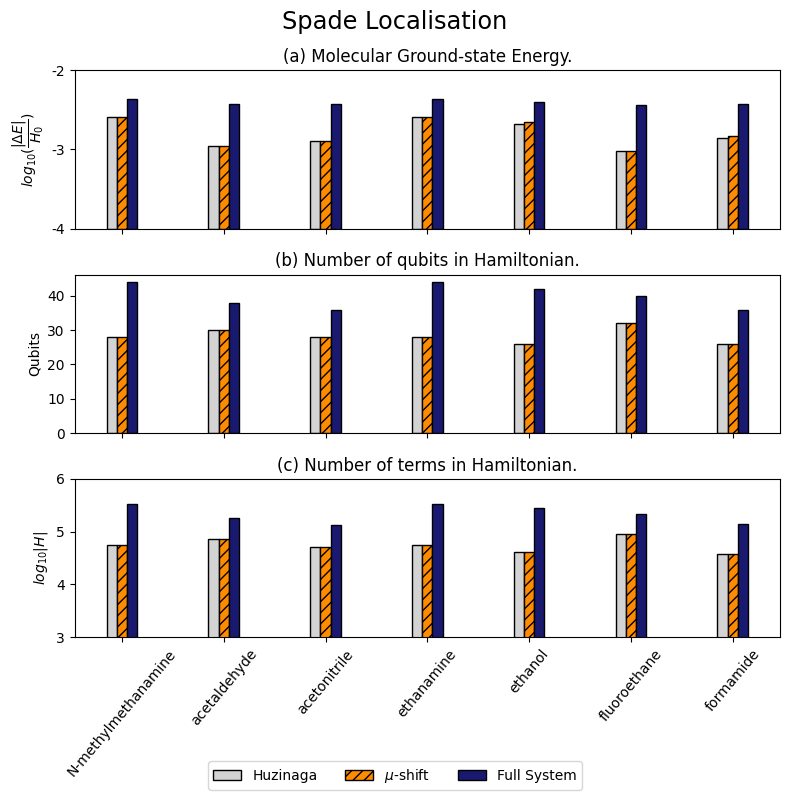

In [164]:
spade_data = format_data(data["spade"])

print_tables("spade", *spade_data)
plot_results("spade", *spade_data)

Ibo Localisation

QUBITS
                     Full  Mu  Huz
N-methylmethanamine    44  22   22
acetaldehyde           38  28   28
acetonitrile           36  26   26
ethanamine             44  26   26
ethanol                42  24   24
fluoroethane           40  26   26
formamide              36  24   24

TERMS
                       Full     Mu    Huz
N-methylmethanamine  338967  20838  20838
acetaldehyde         182702  54011  54259
acetonitrile         136075  34584  35588
ethanamine           329299  40028  40340
ethanol              283020  29737  29737
fluoroethane         217385  38180  38164
formamide            138231  26769  26769

 Full System Values
                    $\epsilon_{DFT}$   Q     |H|
N-methylmethanamine         0.573387  44  338967
acetaldehyde                0.569153  38  182702
acetonitrile                0.484653  36  136075
ethanamine                  0.572698  44  329299
ethanol                     0.609166  42  283020
fluoroethane                0.636886 

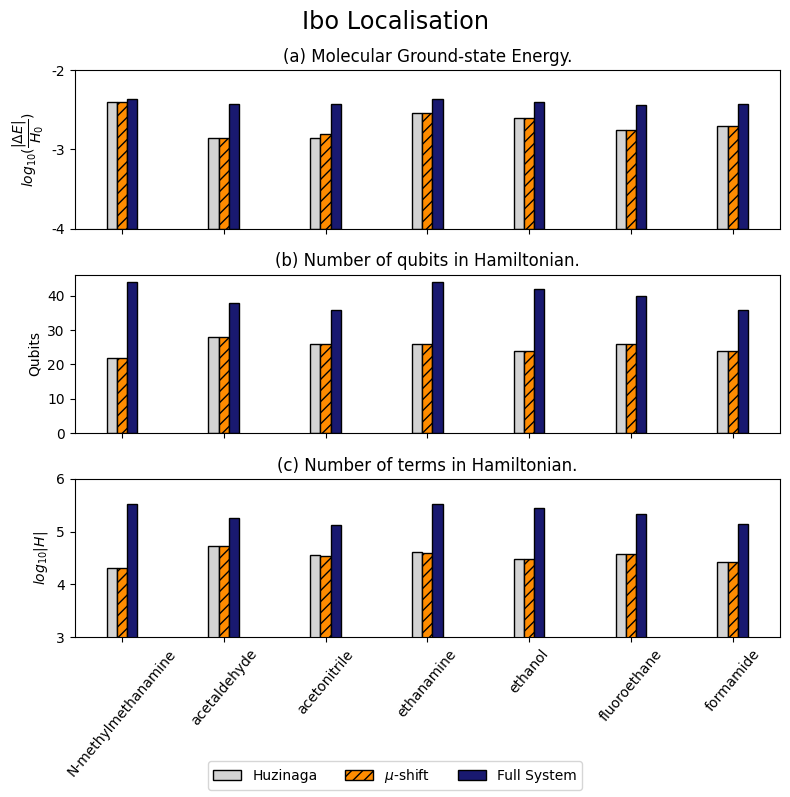

In [165]:
ibo_data = format_data(data["ibo"])

print_tables("ibo", *ibo_data)
plot_results("ibo", *ibo_data)

### Water bond stretching

\begin{tabular}{lrrrrrrllllll}
\toprule
 & bond_length & global_FCI & global_DFT & huz emb FCI & mu emb FCI & global_terms & huz_terms & mu_terms & global_qubits & huz_qubits & mu_qubits & N active MOs \\
\midrule
0 & 0.400000 & -72.981056 & -73.259936 & -72.988008 & -72.988008 & 2110.000000 & 1079 & 1079 & 14 & 12 & 12 & 4 \\
0 & 0.600000 & -74.499220 & -74.773419 & -74.508545 & -74.508545 & 2110.000000 & 1079 & 1079 & 14 & 12 & 12 & 4 \\
0 & 0.798954 & -74.851089 & -75.122053 & -74.864001 & -74.864002 & 1086.000000 & 1079 & 1079 & 14 & 12 & 12 & 4 \\
0 & 1.000000 & -74.900658 & -75.170068 & -74.918225 & -74.918226 & 2110.000000 & 1079 & 1079 & 14 & 12 & 12 & 4 \\
0 & 1.200000 & -74.867498 & -75.134418 & -74.890912 & -74.890913 & 2110.000000 & 1079 & 1079 & 14 & 12 & 12 & 4 \\
0 & 1.500000 & -74.807539 & -75.057383 & -74.840738 & -74.840739 & 2110.000000 & 1079 & 1079 & 14 & 12 & 12 & 4 \\
0 & 2.000000 & -74.776263 & -74.962535 & -74.816902 & -74.816903 & 2110.000000 & 1079 & 1079 & 1

,bond_length,global_FCI,global_DFT,huz emb FCI,mu emb FCI,global_terms,huz_terms,mu_terms,global_qubits,huz_qubits,mu_qubits,N active MOs
0,0.400000,-72.981056,-73.259936,-72.988008,-72.988008,2110.0,1079,1079,14,12,12,4
0,0.600000,-74.499220,-74.773419,-74.508545,-74.508545,2110.0,1079,1079,14,12,12,4
0,0.798954,-74.851089,-75.122053,-74.864001,-74.864002,1086.0,1079,1079,14,12,12,4
0,1.000000,-74.900658,-75.170068,-74.918225,-74.918226,2110.0,1079,1079,14,12,12,4
0,1.200000,-74.867498,-75.134418,-74.890912,-74.890913,2110.0,1079,1079,14,12,12,4
0,1.500000,-74.807539,-75.057383,-74.840738,-74.840739,2110.0,1079,1079,14,12,12,4
0,2.000000,-74.776263,-74.962535,-74.816902,-74.816903,2110.0,1079,1079,14,12,12,4
0,3.000000,-74.771826,-74.890579,-74.820209,-74.820210,2430.0,1211,1175,14,12,12,4
0,4.000000,-74.771720,-74.876127,-74.820269,-74.820269,2314.0,1819,1079,14,12,12,4
0,5.000000,-74.771718,-74.872360,-74.820210,-74.820210,3282.0,1795,1795,14,12,12,4


,bond_length,global_FCI,global_DFT,huz emb FCI,mu emb FCI,global_terms,huz_terms,mu_terms,global_qubits,huz_qubits,mu_qubits,N active MOs
0,0.400000,-72.981056,-73.259936,-72.887821,-72.887827,2110.0,1079,1079,14,12,12,4
0,0.600000,-74.499220,-74.773419,-74.473689,-74.473690,2110.0,1079,1079,14,12,12,4
0,0.798954,-74.851089,-75.122053,-74.864001,-74.864002,1086.0,1079,1079,14,12,12,4
0,1.000000,-74.900658,-75.170068,-74.936101,-74.936101,2110.0,1079,1079,14,12,12,4
0,1.200000,-74.867498,-75.134418,-74.914336,-74.914336,2110.0,1079,1079,14,12,12,4
0,1.500000,-74.807539,-75.057383,-74.847327,-74.847327,2110.0,1079,1079,14,12,12,4
0,2.000000,-74.776263,-74.962535,-74.755507,-74.755507,2110.0,1079,1079,14,12,12,4
0,3.000000,-74.771826,-74.890579,-74.683921,-74.683921,2250.0,1083,1119,14,12,12,4
0,4.000000,-74.771720,-74.874152,-74.667467,-74.667467,2170.0,1159,1159,14,12,12,4
0,5.000000,-74.771718,-74.871551,-74.667841,-74.667841,3062.0,1795,1803,14,12,12,4


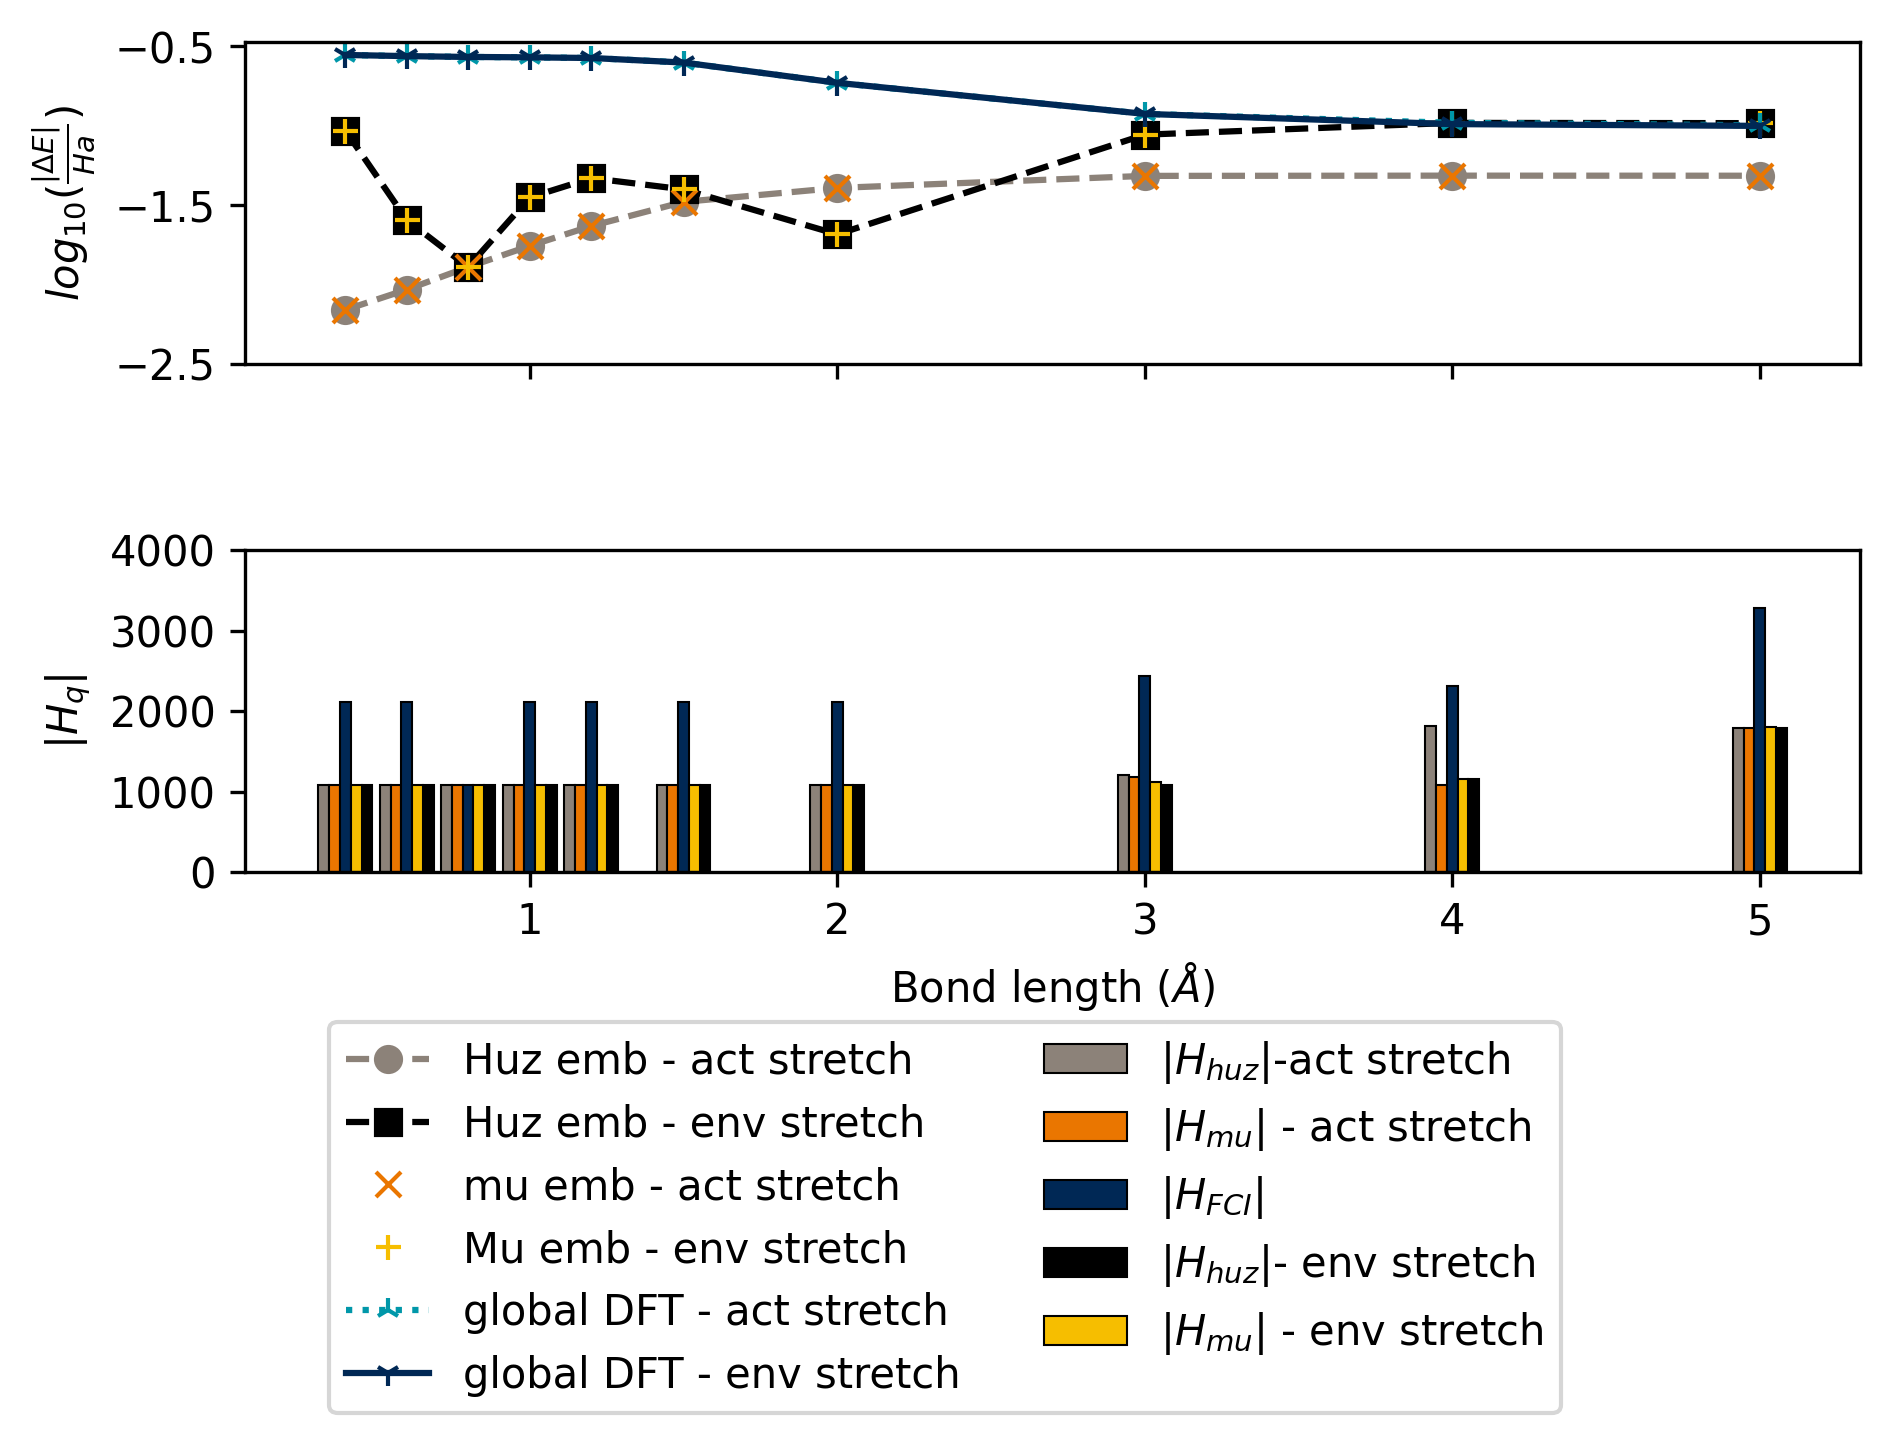

In [166]:
from IPython.display import display

cols = [
    "bond_length",
    "global_FCI",
    "global_DFT",
    "huz emb FCI",
    "mu emb FCI",
    "global_terms",
    "huz_terms",
    "mu_terms",
    "global_qubits",
    "huz_qubits",
    "mu_qubits",
    "N active MOs",
]

pd.set_option("display.max_columns", None)
print(pd.read_pickle("data/spade_act.pkl")[cols].to_latex())
print(pd.read_pickle("data/spade_env.pkl")[cols].to_latex())
display(pd.read_pickle("data/spade_act.pkl")[cols])
display(pd.read_pickle("data/spade_env.pkl")[cols])

plot_water(pd.read_pickle("data/spade_act.pkl"), pd.read_pickle("data/spade_env.pkl"))

,bond_length,global_FCI,global_DFT,huz emb FCI,mu emb FCI,global_terms,huz_terms,mu_terms,global_qubits,huz_qubits,mu_qubits,N active MOs
0,0.400000,-72.981056,-73.259936,-72.935486,-72.923051,2110.0,492,492,14,10,10,3
0,0.600000,-74.499220,-74.773419,-74.484545,-74.484550,2110.0,492,492,14,10,10,3
0,0.798954,-74.851089,-75.122053,-74.852613,-74.852615,1086.0,1079,1079,14,12,12,4
0,1.000000,-74.900658,-75.170068,-74.899540,-74.899542,2110.0,1079,1079,14,12,12,4
0,1.200000,-74.867498,-75.134418,-74.868096,-74.868099,2110.0,1079,1079,14,12,12,4
0,1.500000,-74.807539,-75.057383,-74.819774,-74.819777,2110.0,1079,1079,14,12,12,4
0,2.000000,-74.776263,-74.962535,-74.798954,-74.798956,2110.0,1079,1079,14,12,12,4
0,3.000000,-74.771826,-74.890579,-74.804435,-74.804443,2430.0,876,876,14,10,10,3
0,4.000000,-74.771720,-74.876127,-74.805034,-74.805037,2314.0,1815,1815,14,12,12,4
0,5.000000,-74.771718,-74.872360,-74.804966,-74.804968,3282.0,1759,1759,14,12,12,4


,bond_length,global_FCI,global_DFT,huz emb FCI,mu emb FCI,global_terms,huz_terms,mu_terms,global_qubits,huz_qubits,mu_qubits,N active MOs
0,0.400000,-72.981056,-73.259936,-73.002214,-73.002219,2110.0,1079,1079,14,12,12,4
0,0.600000,-74.499220,-74.773419,-74.519672,-74.519674,2110.0,1079,1079,14,12,12,4
0,0.798954,-74.851089,-75.122053,-74.852613,-74.852615,1086.0,1079,1079,14,12,12,4
0,1.000000,-74.900658,-75.170068,-74.927934,-74.927934,2110.0,1079,1079,14,12,12,4
0,1.200000,-74.867498,-75.134418,-74.911230,-74.911230,2110.0,1079,1079,14,12,12,4
0,1.500000,-74.807539,-75.057383,-74.847005,-74.847005,2110.0,1079,1079,14,12,12,4
0,2.000000,-74.776263,-74.962535,-74.755516,-74.755516,2110.0,1079,1079,14,12,12,4
0,3.000000,-74.771826,-74.890579,-74.683914,-74.683914,2250.0,1095,1119,14,12,12,4
0,4.000000,-74.771720,-74.874152,-74.667459,-74.667459,2170.0,1159,1159,14,12,12,4
0,5.000000,-74.771718,-74.871551,-74.664686,-74.664686,3062.0,1795,1803,14,12,12,4


\begin{tabular}{lrrrrrrllllll}
\toprule
 & bond_length & global_FCI & global_DFT & huz emb FCI & mu emb FCI & global_terms & huz_terms & mu_terms & global_qubits & huz_qubits & mu_qubits & N active MOs \\
\midrule
0 & 0.400000 & -72.981056 & -73.259936 & -72.935486 & -72.923051 & 2110.000000 & 492 & 492 & 14 & 10 & 10 & 3 \\
0 & 0.600000 & -74.499220 & -74.773419 & -74.484545 & -74.484550 & 2110.000000 & 492 & 492 & 14 & 10 & 10 & 3 \\
0 & 0.798954 & -74.851089 & -75.122053 & -74.852613 & -74.852615 & 1086.000000 & 1079 & 1079 & 14 & 12 & 12 & 4 \\
0 & 1.000000 & -74.900658 & -75.170068 & -74.899540 & -74.899542 & 2110.000000 & 1079 & 1079 & 14 & 12 & 12 & 4 \\
0 & 1.200000 & -74.867498 & -75.134418 & -74.868096 & -74.868099 & 2110.000000 & 1079 & 1079 & 14 & 12 & 12 & 4 \\
0 & 1.500000 & -74.807539 & -75.057383 & -74.819774 & -74.819777 & 2110.000000 & 1079 & 1079 & 14 & 12 & 12 & 4 \\
0 & 2.000000 & -74.776263 & -74.962535 & -74.798954 & -74.798956 & 2110.000000 & 1079 & 1079 & 14 & 

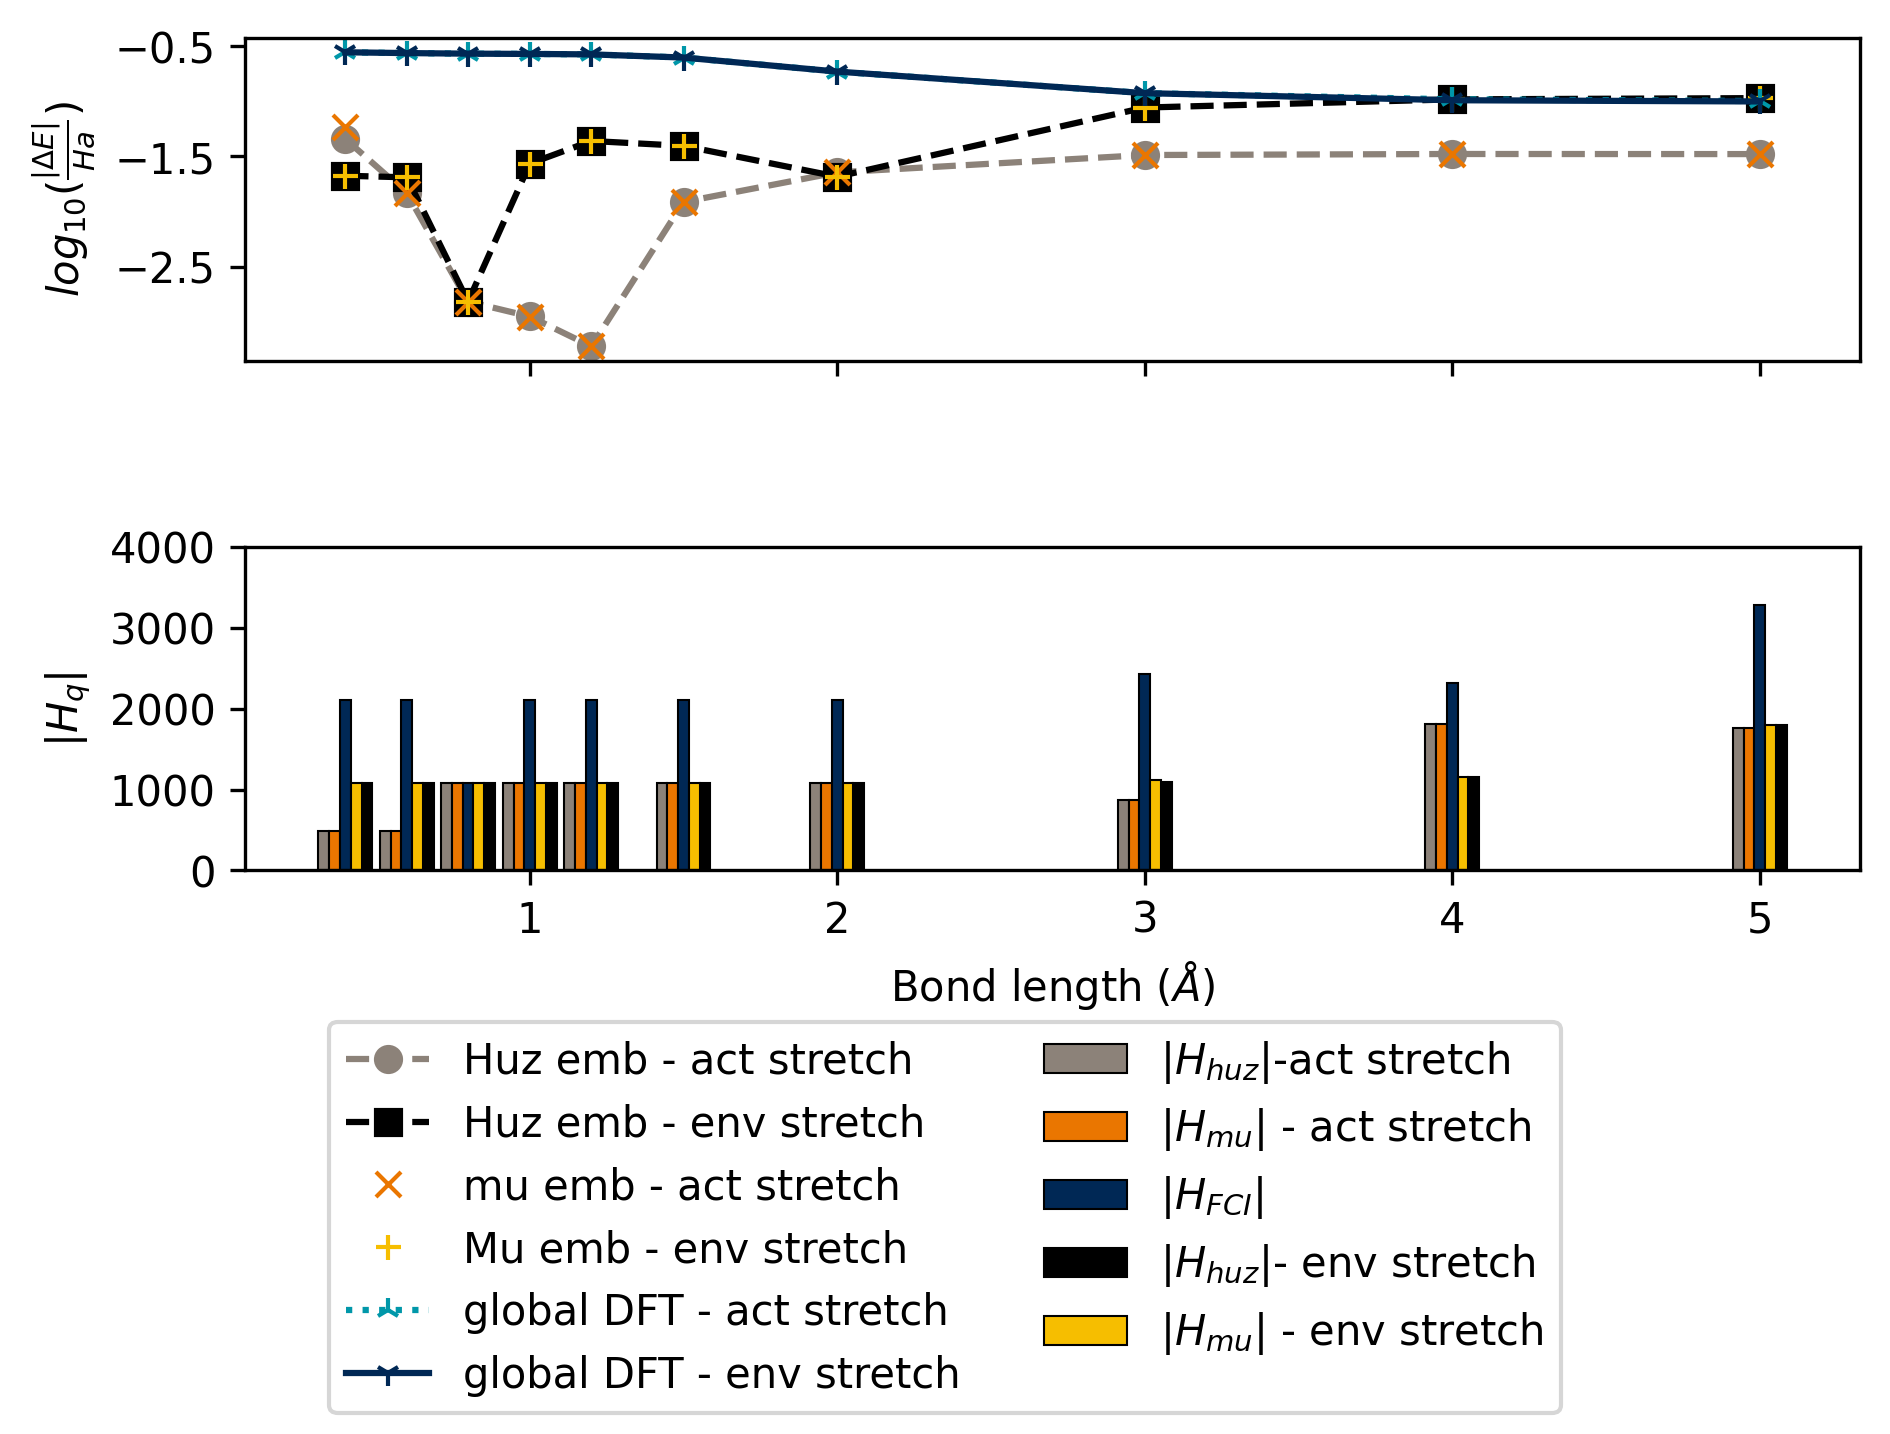

In [167]:
from IPython.display import display

cols = [
    "bond_length",
    "global_FCI",
    "global_DFT",
    "huz emb FCI",
    "mu emb FCI",
    "global_terms",
    "huz_terms",
    "mu_terms",
    "global_qubits",
    "huz_qubits",
    "mu_qubits",
    "N active MOs",
]
pd.set_option("display.max_columns", None)
display(pd.read_pickle("data/ibo_act.pkl")[cols])
display(pd.read_pickle("data/ibo_env.pkl")[cols])
print(pd.read_pickle("data/ibo_act.pkl")[cols].to_latex())
print(pd.read_pickle("data/ibo_env.pkl")[cols].to_latex())

plot_water(pd.read_pickle("data/ibo_act.pkl"), pd.read_pickle("data/ibo_env.pkl"))

,bond_length,global_FCI,global_DFT,huz emb FCI,mu emb FCI,global_terms,huz_terms,mu_terms,global_qubits,huz_qubits,mu_qubits,N active MOs
0,0.400000,-72.981056,-73.259936,-72.935486,-72.923051,2110.0,492,492,14,10,10,3
0,0.600000,-74.499220,-74.773419,-74.484545,-74.484550,2110.0,492,492,14,10,10,3
0,0.798954,-74.851089,-75.122053,-74.852613,-74.852615,1086.0,1079,1079,14,12,12,4
0,1.000000,-74.900658,-75.170068,-74.899540,-74.899542,2110.0,1079,1079,14,12,12,4
0,1.200000,-74.867498,-75.134418,-74.868096,-74.868099,2110.0,1079,1079,14,12,12,4
0,1.500000,-74.807539,-75.057383,-74.819774,-74.819777,2110.0,1079,1079,14,12,12,4
0,2.000000,-74.776263,-74.962535,-74.798954,-74.798956,2110.0,1079,1079,14,12,12,4
0,3.000000,-74.771826,-74.890579,-74.804932,-74.804934,2430.0,1383,1383,14,12,12,4
0,4.000000,-74.771720,-74.876127,-74.805034,-74.805037,2314.0,1815,1815,14,12,12,4
0,5.000000,-74.771718,-74.872360,-74.804966,-74.804968,3282.0,1759,1759,14,12,12,4


,bond_length,global_FCI,global_DFT,huz emb FCI,mu emb FCI,global_terms,huz_terms,mu_terms,global_qubits,huz_qubits,mu_qubits,N active MOs
0,0.400000,-72.981056,-73.259936,-73.002214,-73.002219,2110.0,1079,1079,14,12,12,4
0,0.600000,-74.499220,-74.773419,-74.519672,-74.519674,2110.0,1079,1079,14,12,12,4
0,0.798954,-74.851089,-75.122053,-74.852613,-74.852615,1086.0,1079,1079,14,12,12,4
0,1.000000,-74.900658,-75.170068,-74.927934,-74.927934,2110.0,1079,1079,14,12,12,4
0,1.200000,-74.867498,-75.134418,-74.911230,-74.911230,2110.0,1079,1079,14,12,12,4
0,1.500000,-74.807539,-75.057383,-74.847005,-74.847005,2110.0,1079,1079,14,12,12,4
0,2.000000,-74.776263,-74.962535,-74.755516,-74.755516,2110.0,1079,1079,14,12,12,4
0,3.000000,-74.771826,-74.890579,-74.683914,-74.683914,2250.0,1095,1119,14,12,12,4
0,4.000000,-74.771720,-74.874152,-74.667459,-74.667459,2170.0,1159,1159,14,12,12,4
0,5.000000,-74.771718,-74.871551,-74.664686,-74.664686,3062.0,1795,1803,14,12,12,4


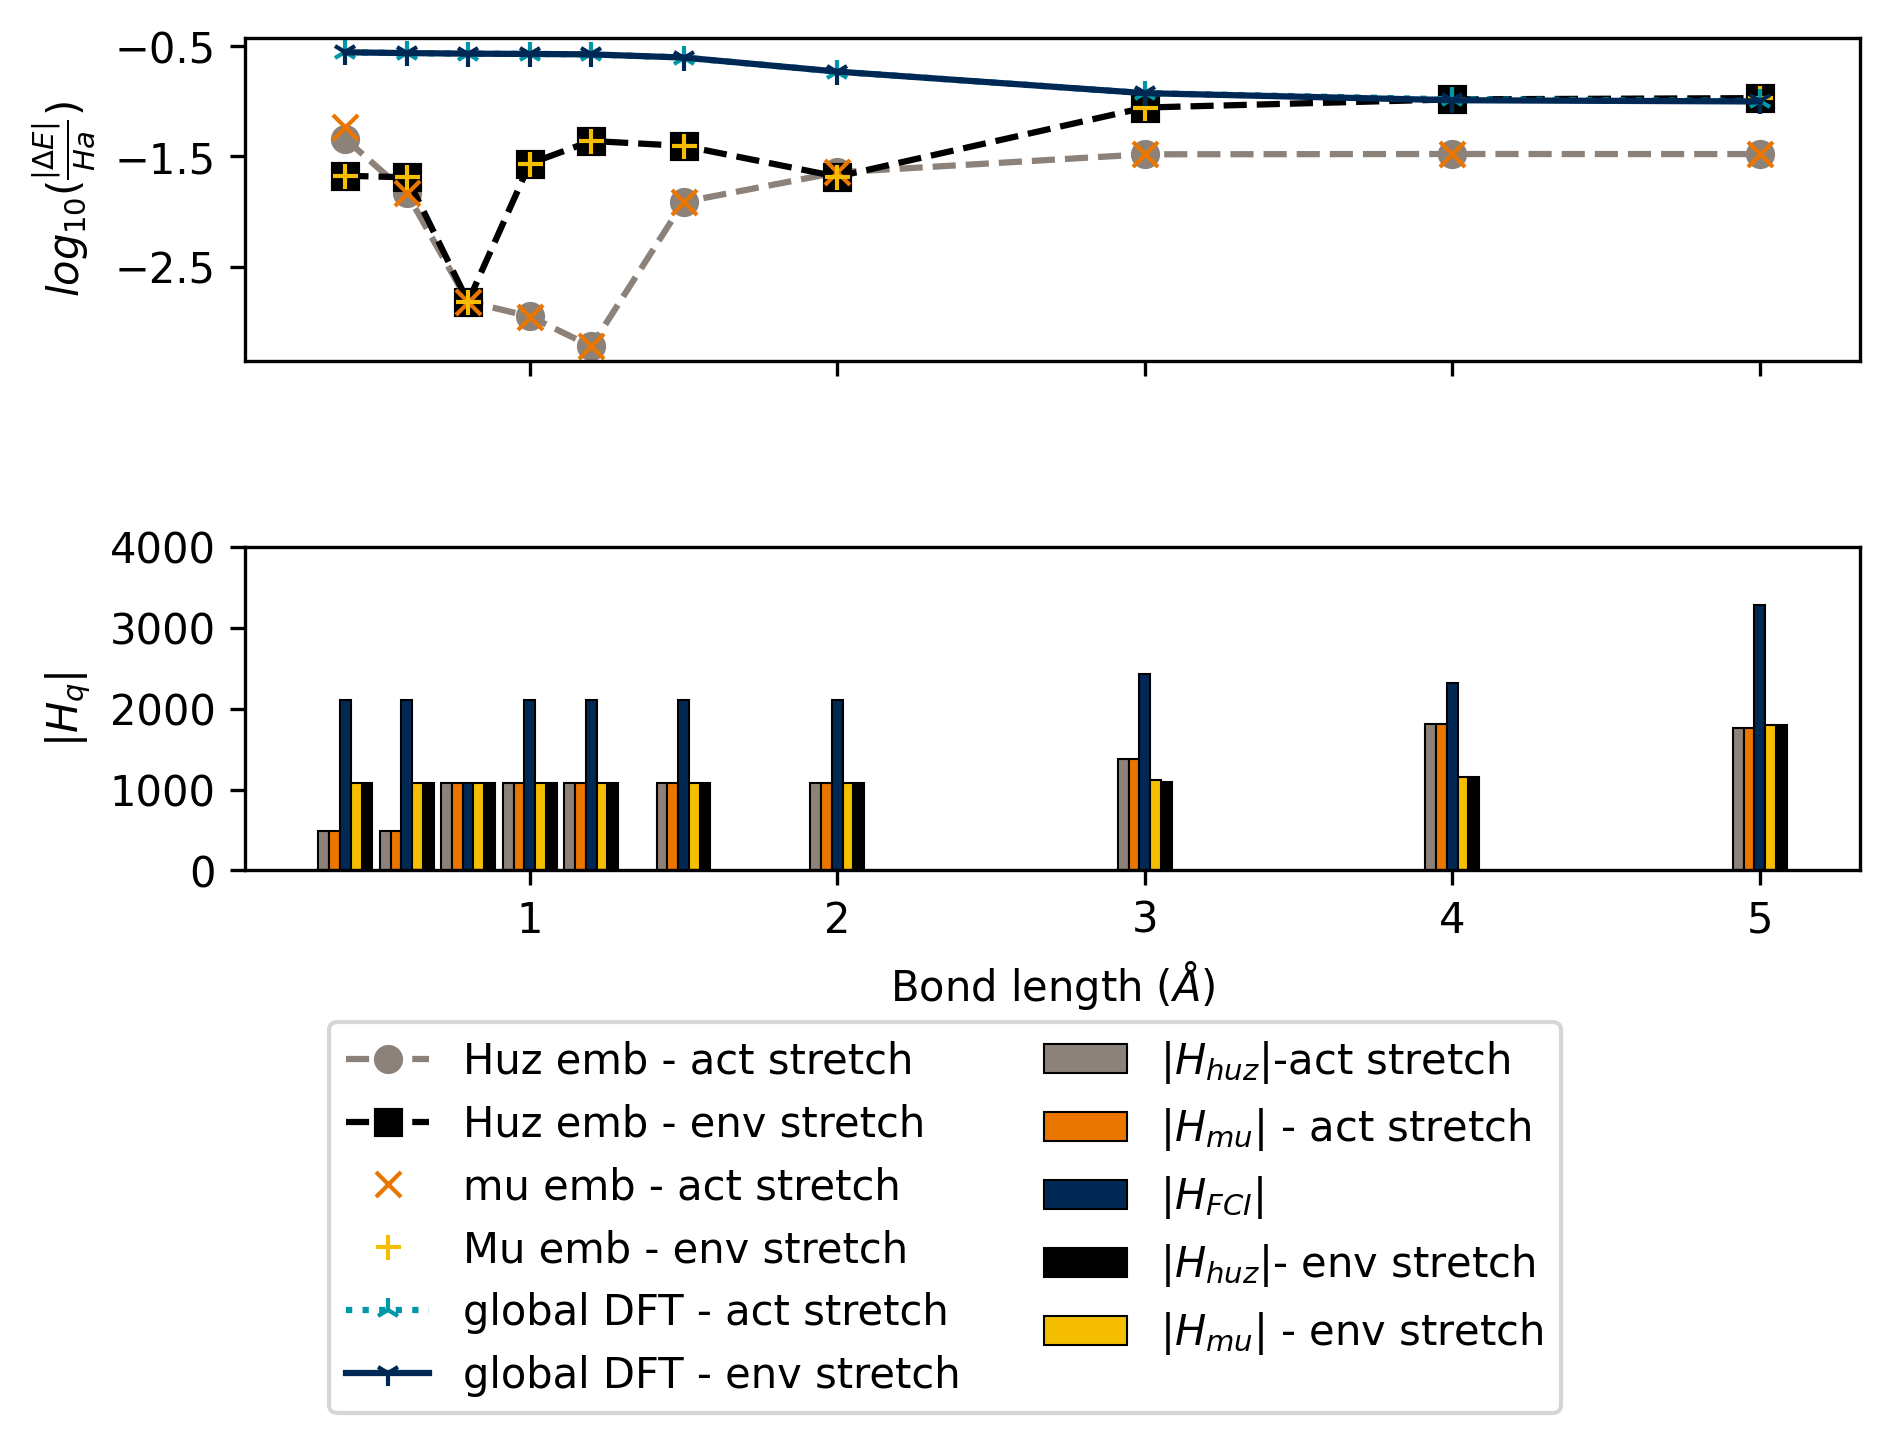

In [144]:
from IPython.display import display

cols = [
    "bond_length",
    "global_FCI",
    "global_DFT",
    "huz emb FCI",
    "mu emb FCI",
    "global_terms",
    "huz_terms",
    "mu_terms",
    "global_qubits",
    "huz_qubits",
    "mu_qubits",
    "N active MOs",
]

pd.set_option("display.max_columns", None)
display(pd.read_pickle("data/ibo_90_act.pkl")[cols])
display(pd.read_pickle("data/ibo_90_env.pkl")[cols])

plot_water(pd.read_pickle("data/ibo_90_act.pkl"), pd.read_pickle("data/ibo_90_env.pkl"))

### Cyclopentane Results

/var/folders/b6/r25qxhld1ls1sll052q1dw5h0000gn/T/ipykernel_98672/2101974098.py:93: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


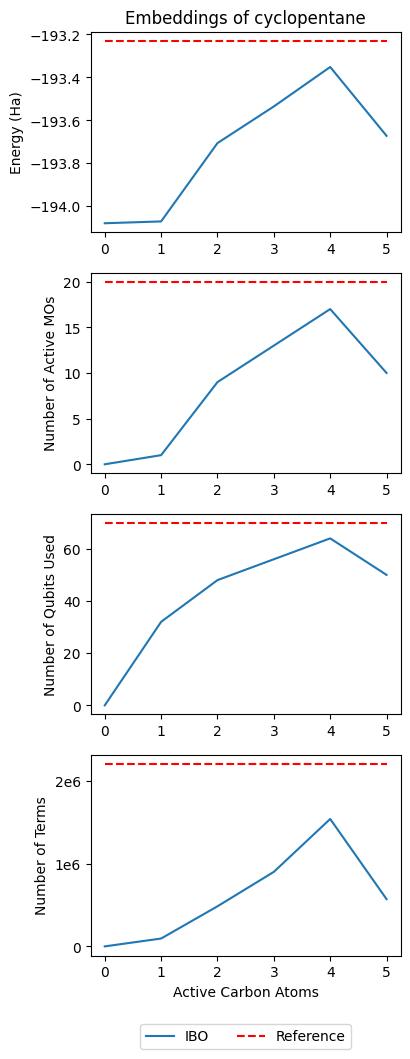

In [160]:
plot_cyclopentane(pd.read_json("data/cyclopentane_spade.json"))

/var/folders/b6/r25qxhld1ls1sll052q1dw5h0000gn/T/ipykernel_98672/2101974098.py:93: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


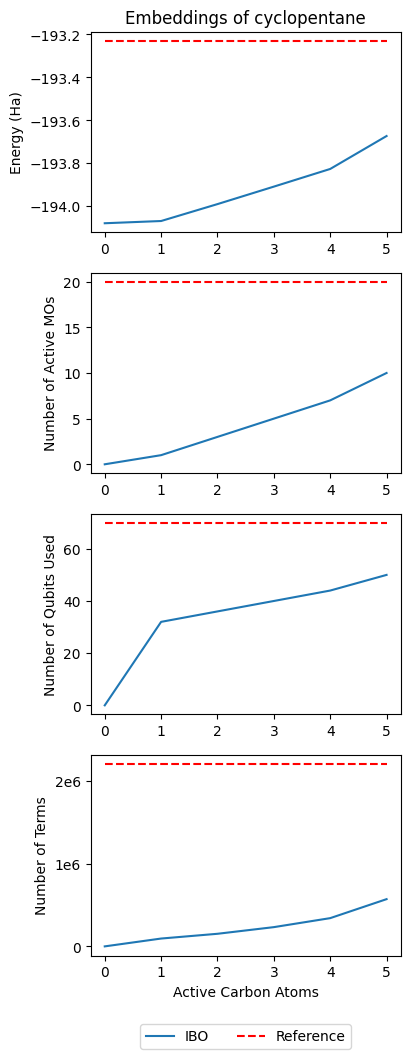

In [161]:
plot_cyclopentane(pd.read_json("data/cyclopentane_ibo.json"))

/var/folders/b6/r25qxhld1ls1sll052q1dw5h0000gn/T/ipykernel_98672/2101974098.py:93: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


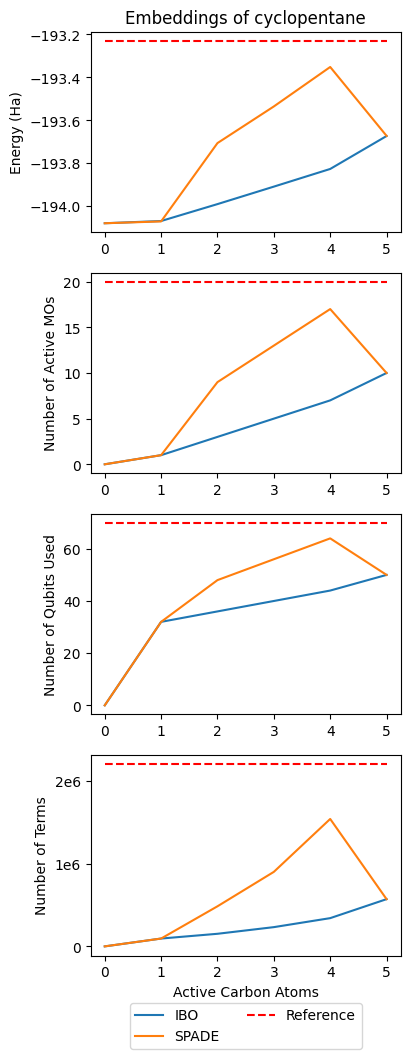

In [162]:
plot_cyclopentane(
    pd.read_json("data/cyclopentane_ibo.json"),
    pd.read_json("data/cyclopentane_spade.json"),
)